In [29]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.metrics import roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [2]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0][1:]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1][:-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [3]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",index_col=0).T

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_4751/346269195.py:2: SyntaxWarning: invalid escape sequence '\ '
  dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0).T
/tmp/ipykernel_4751/346269195.py:4: SyntaxWarning: invalid escape sequence '\ '
  df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0).T
/tmp/ipykernel_4751/346269195.py:5: SyntaxWarning: invalid escape sequence '\ '
  df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimi

In [4]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [12]:
df_drop = pd.concat([df3, df4])
df_drop = df_drop.fillna(0)

df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])


df_smart = pd.concat([dffn, df2fn])
df_smart = df_smart.fillna(0)

df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(0)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

In [14]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.data[index, :], dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class NNClassifier(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNClassifier, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H3, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.layers(x)

In [15]:
input_size = df_all.shape[1]
learning_rate = 1e-3
num_epochs = 100

hidden_size = 1024
hidden_size1 = 512
hidden_size2 = 256

test_amount = 0.2

In [16]:
df_train, df_test = train_test_split(df_all, test_size=test_amount)
df_train_smart = df_train[[i in df_smart.index for i in df_train.index]]
df_train_drop = df_train[[i in df_drop.index for i in df_train.index]]

dataset = NNDataset(df_train, df_all_norm_idx)
dataset_drop = NNDataset(df_train_drop, df_drop_norm_idx)
dataset_smart = NNDataset(df_train_smart, df_smart_norm_idx)

data_loader = DataLoader(dataset, batch_size=512, shuffle=True)
data_loader_drop = DataLoader(dataset_drop, batch_size=256, shuffle=True)
data_loader_smart = DataLoader(dataset_smart, batch_size=16, shuffle=True)

# Define the model
model = NNClassifier(input_size, hidden_size, hidden_size1, hidden_size2).to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
model

NNClassifier(
  (layers): Sequential(
    (0): Linear(in_features=8645, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=1, bias=True)
    (19): Sigmoid()
  )
)

In [18]:
train_config = [
    [200, data_loader_smart],
    [10, data_loader_drop],
    [20, data_loader],
    [200, data_loader_smart],
    [20, data_loader]
]

In [19]:
# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs[:, 0], labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}")

Epoch 1, Loss: 15.192751851575128
Epoch 2, Loss: 17.600574756490772
Epoch 3, Loss: 17.636494274797112
Epoch 4, Loss: 17.67241379310345
Epoch 5, Loss: 17.744252895486767
Epoch 6, Loss: 17.564655172413794
Epoch 7, Loss: 17.600574756490772
Epoch 8, Loss: 17.600574756490772
Epoch 9, Loss: 17.708333377180427
Epoch 10, Loss: 17.67241379310345
Epoch 11, Loss: 17.708333377180427
Epoch 12, Loss: 17.636494274797112
Epoch 13, Loss: 17.708333377180427
Epoch 14, Loss: 17.636494274797112
Epoch 15, Loss: 17.636494274797112
Epoch 16, Loss: 17.67241379310345
Epoch 17, Loss: 17.636494274797112
Epoch 18, Loss: 17.708333377180427
Epoch 19, Loss: 17.67241379310345
Epoch 20, Loss: 17.45689655172414
Epoch 21, Loss: 17.67241379310345
Epoch 22, Loss: 17.708333377180427
Epoch 23, Loss: 17.636494274797112
Epoch 24, Loss: 17.74425296125741
Epoch 25, Loss: 17.600574756490772
Epoch 26, Loss: 17.74425296125741
Epoch 27, Loss: 17.74425296125741
Epoch 28, Loss: 17.74425296125741
Epoch 29, Loss: 17.67241379310345
Epoch

In [27]:
@torch.no_grad
def measure_model(model, data_loader):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = outputs[:, 0]
        total += labels.size(0)
        correct += (predicted +0.5 > labels).sum().item()
        y_pred_class.extend(predicted.cpu().round()) # Save Prediction
        y_pred.extend(predicted.cpu()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    print("F1 Score:", f1_score(y_true, y_pred_class))
    print("Recall:", recall_score(y_true, y_pred_class))
    print(f'Accuracy of the network on the {total} test images: {(correct / total) * 100}%')


In [25]:
dataset_test = NNDataset(df_test, df_all_norm_idx)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

df_test_smart = df_test[[i in df_smart.index for i in df_test.index]]
dataset_test_smart = NNDataset(df_test_smart, df_smart_norm_idx)
test_loader_smart = DataLoader(dataset_test_smart, batch_size=64, shuffle=True)

df_test_drop = df_test[[i in df_drop.index for i in df_test.index]]
dataset_test_drop = NNDataset(df_test_drop, df_drop_norm_idx)
test_loader_drop = DataLoader(dataset_test_drop, batch_size=64, shuffle=True)

F1 Score: 0.9574851128652542
Recall: 0.95181718061674
Accuracy of the network on the 7348 test images: 97.61839956450736%


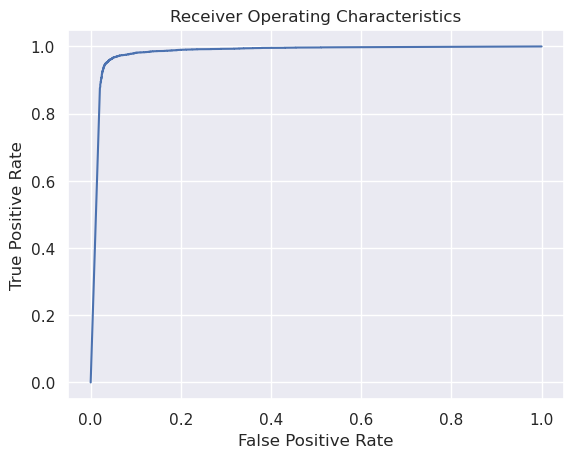

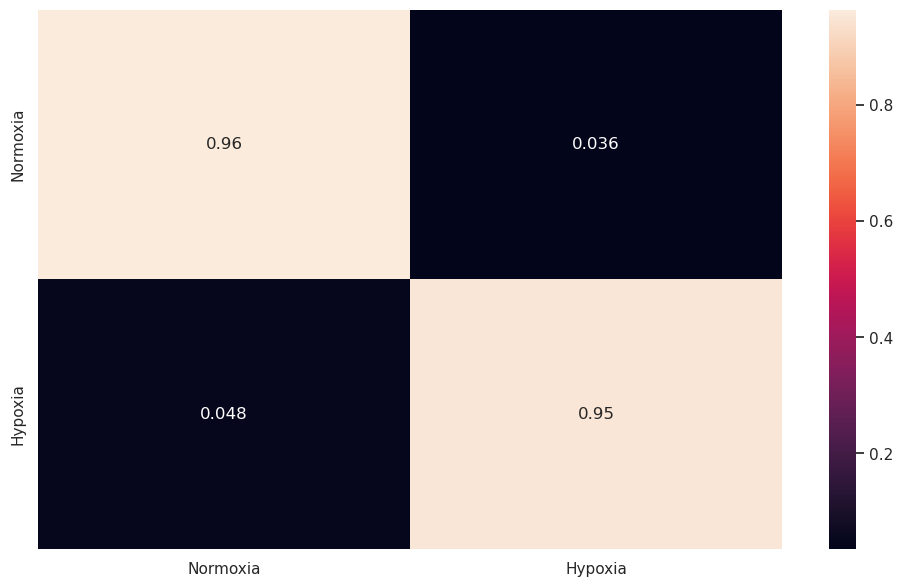

In [31]:
measure_model(model, test_loader)

F1 Score: 0.8311688311688312
Recall: 0.9142857142857143
Accuracy of the network on the 84 test images: 96.42857142857143%


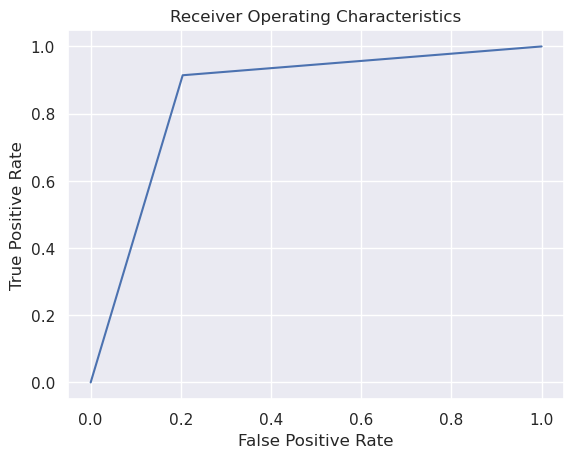

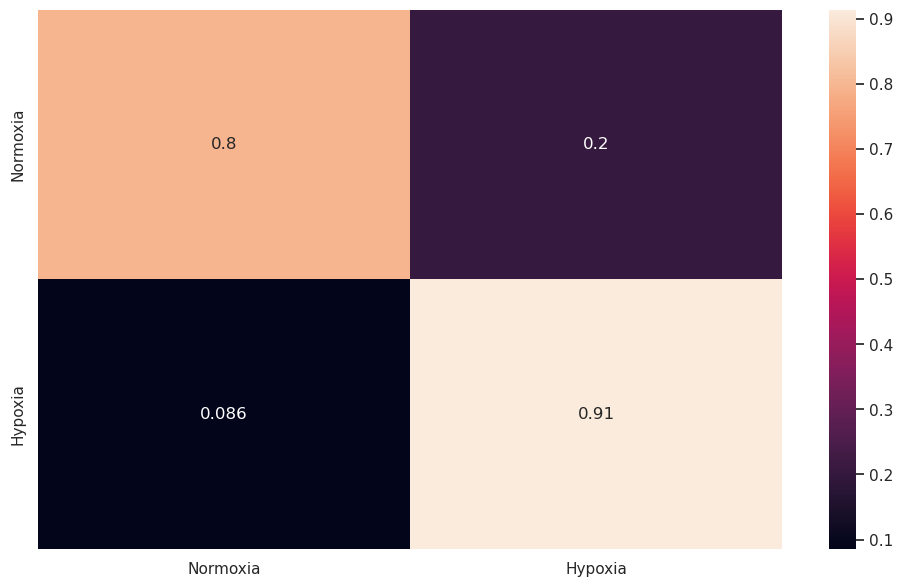

In [32]:
measure_model(model, test_loader_smart)

F1 Score: 0.9579596412556054
Recall: 0.9502363080344731
Accuracy of the network on the 7264 test images: 97.53579295154185%


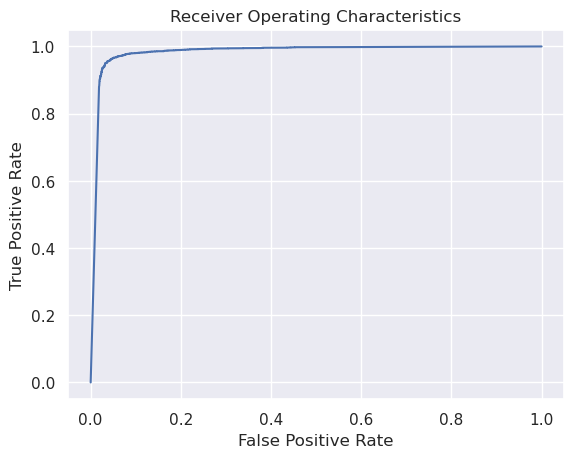

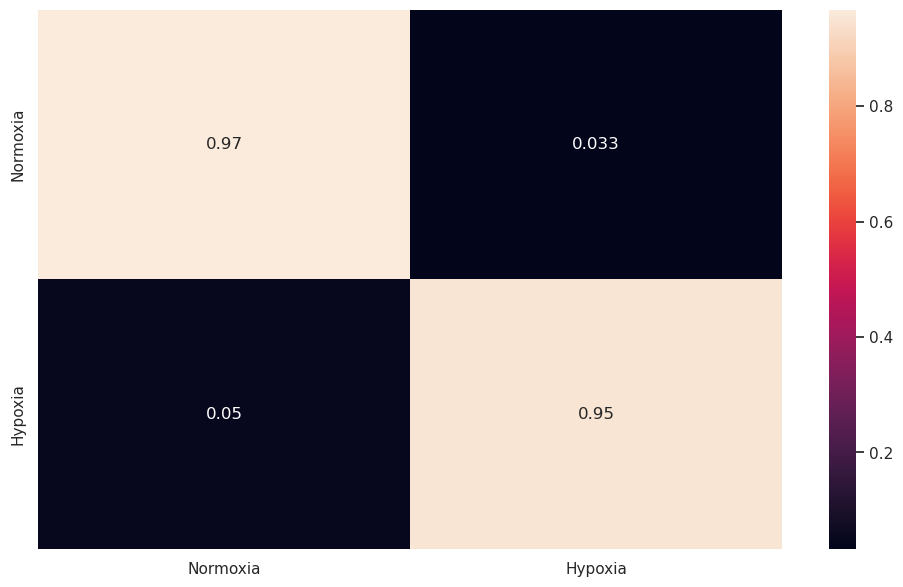

In [33]:

measure_model(model, test_loader_drop)